In [1]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model, Input
import tensorflow as tf
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from typing import List
import cv2

In [2]:
def build_pretrained_resnetmodel():
  """Build a pre-trained resnet with a bounding box head.
    
    Returns:
        pretrained_resnet_model: A resnet50 model pre-trained on the imagenet
            dataset, with a modified head that outputs bounding box coordinates.
    """
  # The imagenet dataset contains 1000 classes, so include_top=False removes
  # the final fully connected layer for the 1000 class classification
  resnet = tf.keras.applications.ResNet50(
      weights="imagenet",
      include_top=False,
      input_tensor=Input(shape=(256, 256, 3))
  )
  # By default, a pretrained model will have all the layers be untrainable,
  # but we want to fine tune on a drone dataset, so we set this to True
  resnet.trainable = True

  flatten = resnet.output
  flatten = Flatten()(flatten)

  bboxHead = Dense(128, activation="relu")(flatten)
  bboxHead = Dense(64, activation="relu")(bboxHead)
  bboxHead = Dense(32, activation="relu")(bboxHead)
  # The linear activation outputs the four values corresponding to the
  # coordinates of the bounding box
  bboxHead = Dense(4, activation="linear")(bboxHead)

  resnetmodel = Model(inputs=resnet.input, outputs=bboxHead)
  return resnetmodel


resnetmodel = build_pretrained_resnetmodel()

In [ ]:
# training_images = []
# training_annotations = []

# image_filenames = glob.glob("drone_dataset_yolo/dataset_txt/*.jpg")

# for filename in image_filenames:
#   Load_image = Image.open(filename).convert('RGB')
#   nmpy_img = Load_image.resize((256, 256))
#   training_images.append(np.asarray(nmpy_img))

#   seperate_path = image.split('.')
#   seperate_path[1] = '.txt'

#   try:
#     with open(seperate_path[0] + seperate_path[1]) as f:
#       lines = f.readlines()
#       tmp_lst = lines[0].split(' ')
#       #label = int(tmp_lst[0])
#       startX = float(tmp_lst[1])
#       startY = float(tmp_lst[2])
#       endX = float(tmp_lst[3])
#       endY = float(tmp_lst[4])
#       training_annotations.append((startX, startY, endX, endY))
#   except:
#     continue

In [3]:
def draw_bounding_box_on_image(image: np.ndarray, bbox: List[float]):
  """Draw bounding boxes on an image.
  
  Args:
    image: HxWx3 np array image
    bbox: List of 4 floats in the format (center_x, center_y, width, height)
  """
  height, width, _ = image.shape
  center_x, center_y, box_width, box_height = bbox
  center_x_abs = int(center_x * width)
  center_y_abs = int(center_y * height)
  width_abs = int(box_width * width)
  height_abs = int(box_height * height)

  top_left_corner = (
      center_x_abs - width_abs // 2, center_y_abs - height_abs // 2
  )
  bottom_right_corner = (
      center_x_abs + width_abs // 2, center_y_abs + height_abs // 2
  )

  # Draw rectangle on image. Note that OpenCV uses top-left and bottom-right points of the rectangle.
  cv2.rectangle(
      image,
      top_left_corner,
      bottom_right_corner,
      color=(255, 0, 0),
      thickness=2
  )

  return image

In [6]:
image_filenames = glob.glob("Database1/*.JPEG")
dataset_images = []
dataset_annotations = []

for filename in image_filenames:
  try:
    loaded_image = Image.open(filename).convert('RGB').resize((256, 256))
  except:
    continue
  loaded_image = np.asarray(loaded_image).copy()

  annotation_filename = filename.split('.')[0] + '.txt'
  try:
    with open(annotation_filename) as f:
      lines = f.readlines()
      if not lines:
        continue
      # This could return a list of multiple annotations, but we just grab
      # the first one and split it into the individual coordinates
      coordinates_as_strings = lines[0].split(' ')
      # Ignore index 0, since that is for a binary classification task in the
      # chosen dataset
      center_x = float(coordinates_as_strings[1])
      center_y = float(coordinates_as_strings[2])
      width = float(coordinates_as_strings[3])
      height = float(coordinates_as_strings[4])
      bbox = (center_x, center_y, width, height)
  except:
    continue
  dataset_images.append(loaded_image)
  dataset_annotations.append(bbox)

In [7]:
print(
    f'There are {len(dataset_images)} images and {len(dataset_annotations)} annotations'
)

There are 2863 images and 2863 annotations


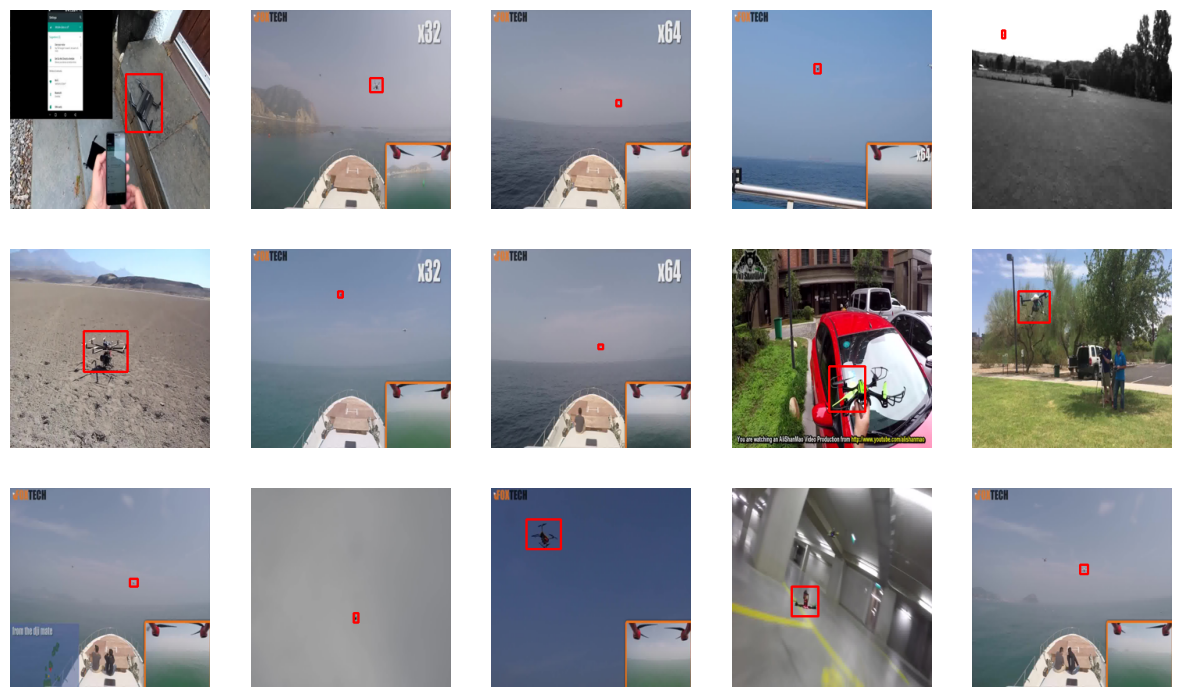

In [8]:
plt.figure(figsize=(15, 15))

for i in range(15):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(
      draw_bounding_box_on_image(dataset_images[i], dataset_annotations[i])
  )
  plt.axis("off")

In [9]:
from sklearn.model_selection import train_test_split

data = np.array(
    dataset_images
)  # memory not sufficient !!
targets = np.array(dataset_annotations)

split = train_test_split(data, targets, test_size=0.10, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]

# Printing the shapes of the data and targets arrays

data.shape, targets.shape

((2863, 256, 256, 3), (2863, 4))

In [15]:
def iou(y_true, y_pred):
    # Convert (center_x, center_y, width, height) to (x_min, y_min, x_max, y_max)
    cx_true, cy_true, w_true, h_true = tf.split(y_true, 4, axis=-1)
    cx_pred, cy_pred, w_pred, h_pred = tf.split(y_pred, 4, axis=-1)

    xmin_true = cx_true - w_true / 2
    ymin_true = cy_true - h_true / 2
    xmax_true = cx_true + w_true / 2
    ymax_true = cy_true + h_true / 2

    xmin_pred = cx_pred - w_pred / 2
    ymin_pred = cy_pred - h_pred / 2
    xmax_pred = cx_pred + w_pred / 2
    ymax_pred = cy_pred + h_pred / 2

    # Calculate intersection area
    intersect_xmin = tf.maximum(xmin_true, xmin_pred)
    intersect_ymin = tf.maximum(ymin_true, ymin_pred)
    intersect_xmax = tf.minimum(xmax_true, xmax_pred)
    intersect_ymax = tf.minimum(ymax_true, ymax_pred)

    intersect_area = tf.maximum(intersect_xmax - intersect_xmin, 0) * \
                     tf.maximum(intersect_ymax - intersect_ymin, 0)

    # Calculate union area
    true_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)
    pred_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    union_area = true_area + pred_area - intersect_area

    # Compute the IoU
    iou = intersect_area / tf.maximum(union_area, tf.keras.backend.epsilon())

    return tf.reduce_mean(iou)

# When compiling the model, replace 'accuracy' with the iou function
resnetmodel.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01),
    loss='mse',
    metrics=[iou]  # Replace 'accuracy' with the iou metric
)

save_best = tf.keras.callbacks.ModelCheckpoint(
    "DroneDetectorRESNET_epoch{epoch:02d}_valiou{val_iou:.4f}.h5", 
    monitor='val_iou', 
    verbose=1, 
    save_best_only=True, 
    mode='max'
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='iou',
    min_delta=0.01,
    patience=3,
    mode='max',
    baseline=None,
    restore_best_weights=True
)

historyresnet = resnetmodel.fit(
    trainImages,
    trainTargets,
    validation_split=0.2,
    batch_size=32,
    epochs=50,
    verbose=1,
    callbacks=[save_best, early_stopping]
)

Epoch 1/50
65/65 [==============================] - ETA: 0s - loss: 1.7913 - iou: 0.0236
Epoch 1: val_iou improved from -inf to 0.00000, saving model to DroneDetectorRESNET_epoch01_valiou0.0000.h5


/Users/scotttw/Projects/Hackathon2024/backend/drone_detection/MLEnv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


65/65 [==============================] - 352s 5s/step - loss: 1.7913 - iou: 0.0236 - val_loss: 38134641328128.0000 - val_iou: 0.0000e+00
Epoch 2/50
65/65 [==============================] - ETA: 0s - loss: 0.0282 - iou: 0.0429
Epoch 2: val_iou did not improve from 0.00000
65/65 [==============================] - 404s 6s/step - loss: 0.0282 - iou: 0.0429 - val_loss: 247940800.0000 - val_iou: 0.0000e+00
Epoch 3/50
65/65 [==============================] - ETA: 0s - loss: 0.0187 - iou: 0.0565
Epoch 3: val_iou improved from 0.00000 to 0.00019, saving model to DroneDetectorRESNET_epoch03_valiou0.0002.h5
65/65 [==============================] - 408s 6s/step - loss: 0.0187 - iou: 0.0565 - val_loss: 109.3252 - val_iou: 1.9024e-04
Epoch 4/50
65/65 [==============================] - ETA: 0s - loss: 0.0177 - iou: 0.0593
Epoch 4: val_iou improved from 0.00019 to 0.01238, saving model to DroneDetectorRESNET_epoch04_valiou0.0124.h5
65/65 [==============================] - 393s 6s/step - loss: 0.0177 -

KeyboardInterrupt: 

In [16]:
resnetmodel = tf.keras.models.load_model('./DroneDetectorRESNET_epoch07_valiou0.0770.h5')
resnetmodel.predict(testImages[:10], verbose=1)

ValueError: Unknown metric function: 'iou'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
for i in range(10):
  detect_drone_bounding_box(testImages[i])

In [ ]:
def detect_drone_bounding_box(image: np.ndarray) -> List[float]:
  """Run inference on the input image and return a bounding box.

  This function resizes the input image to (256, 256), runs the drone detection
  model on it, and then outputs a bounding box in relative float coordinates in
  the form of (center_x, center_y, width, height).
  
  Args:
    image: HxWx3 input image.
  Returns:
    bbox: (center_x, center_y, width, height) of the drone.
  """
  height, width, _ = image.shape
  resized_image = cv2.resize(
      image.astype(np.float32), (256, 256), interpolation=cv2.INTER_AREA
  )
  bbox = list(resnetmodel.predict(resized_image[np.newaxis, :])[0])
  print(f'Model bbox: {bbox}')

  return bbox

In [ ]:
filename = "Database1/4.JPEG"
Load_image = Image.open(filename).convert('RGB')
nmpy_img = np.asarray(Load_image.resize((256, 256)))
plt.imshow(nmpy_img)

In [ ]:
bbox = detect_drone_bounding_box(nmpy_img / 255.0)
plt.imshow(draw_bounding_box_on_image(nmpy_img.copy(), bbox))

In [ ]:
import cv2
import numpy as np
from IPython.display import display, clear_output
from PIL import Image

# Open a handle to the default webcam
cap = cv2.VideoCapture(1)

try:
  while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    if not ret:
      print("Failed to grab frame")
      break

    # Convert the image color to something compatible with Jupyter Notebook
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # bbox = detect_drone(frame)
    # print(bbox)
    # frame = draw_bounding_box_on_image(frame, bbox)

    # Convert the image to PIL format
    im_pil = Image.fromarray(frame)

    # Display the image
    display(im_pil)

    # Clear the output after each frame; wait a bit to be visible
    clear_output(wait=True)

except KeyboardInterrupt:
  # Release the capture when interrupted
  cap.release()
  print("Stream stopped")
finally:
  cap.release()
  print("Stream stopped")
